In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.random.utils import params_broadcast_shapes
from sklearn.preprocessing import MaxAbsScaler
from scipy.stats import pearsonr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [3]:
raw = pd.read_csv('MMM_test_data.csv')
df=raw.copy()

In [4]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'])
date_data= df['start_of_week']
channel_data = df[spend_channels]
control_data=None
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)

In [5]:
df['day'] = pd.to_datetime(df.start_of_week).dt.dayofyear
n_order = 3
periods = df["day"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
# trend feature

df['t'] = (df.index - df.index.min()) / (df.index.max() - df.index.min())

control_data = pd.concat([df['t'], fourier_features], axis=1)
control_data.head()


,t,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3
0,0.000000,-0.861693,-0.507430,0.874498,-0.485029,-0.025801,0.999667
1,0.009709,0.363482,-0.931601,-0.677240,0.735762,0.898354,-0.439273
2,0.019417,-0.957852,-0.287261,0.550307,-0.834962,0.641689,0.766965
3,0.029126,-0.985424,-0.170118,0.335276,-0.942120,0.871351,0.490660
4,0.038835,-0.998724,-0.050511,0.100892,-0.994897,0.988531,0.151016


In [6]:
target_scaler = MaxAbsScaler()
target_scaler.fit(target_data.values.reshape(-1,1))
target_scaled = pd.Series(target_scaler.transform(target_data.values.reshape(-1,1)).flatten())

channel_scaler = MaxAbsScaler()
channel_scaler.fit(channel_data)
channel_scaled = pd.DataFrame(channel_scaler.transform(channel_data),columns=channel_data.columns)

<Axes: >

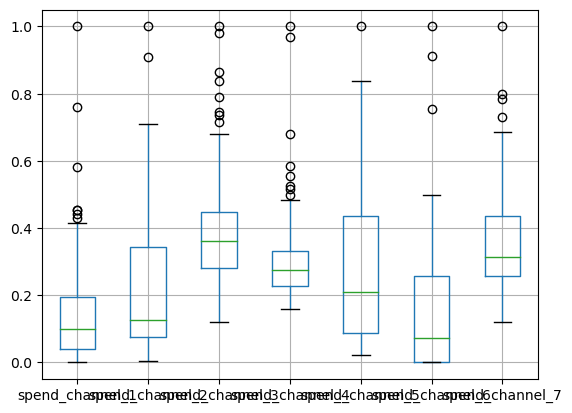

In [7]:
channel_scaled.boxplot()

In [8]:
coords={"date": date_data,
        "channel": channel_scaled,
        "control":control_data}

In [9]:
max_lag=13

with pm.Model(coords=coords) as model:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    control_data_ = pm.MutableData(
        name="control_data", value=control_data, dims=("date", "control")
    )
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=2, beta=5, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=2, dims="control"
    )
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=1)
    
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var = intercept + channel_contributions.sum(axis=-1)

    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=control_data_ * fourier_control,
        dims=("date", "control"),
    )
    
    mu_var += control_contributions.sum(axis=-1)

    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.StudentT(
        name="likelihood",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=target_,
        dims="date",
    )
    model_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


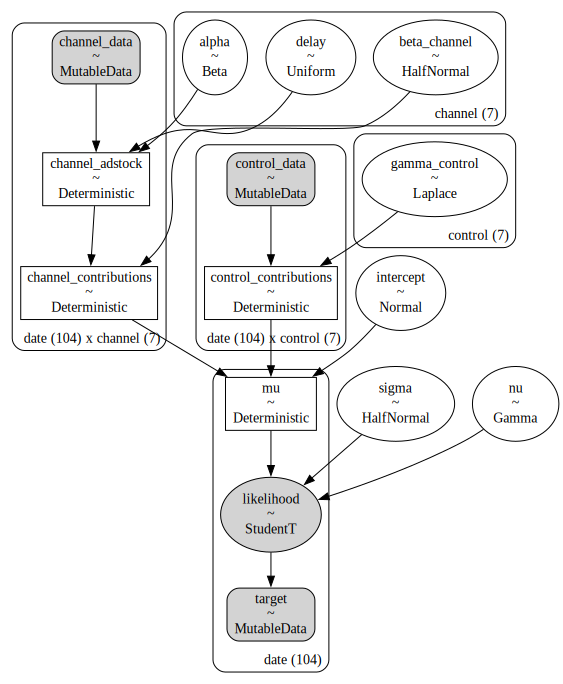

In [10]:
pm.model_to_graphviz(model=model)

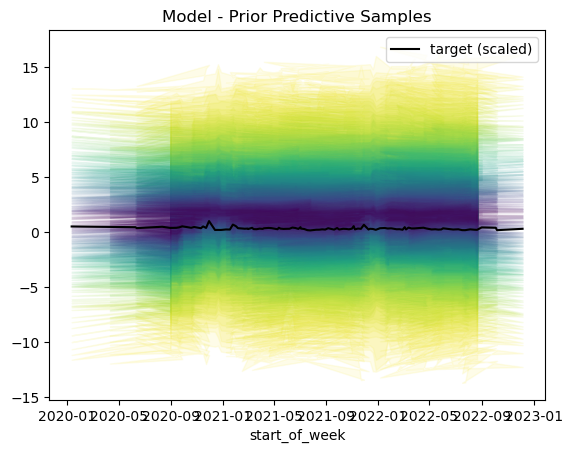

In [11]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


In [12]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:05.495830
Sampling...


Compiling.. :   0%|                                                        | 0/9000 [00:00<?, ?it/s]

  0%|                                                                      | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                        | 0/9000 [00:00<?, ?it/s]


  0%|                                                                      | 0/9000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                     | 0/9000 [00:05<?, ?it/s]


Running chain 3:   0%|                                                     | 0/9000 [00:05<?, ?it/s]

Running chain 0:   5%|██                                        | 450/9000 [00:09<01:20, 106.27it/s]


Running chain 3:   5%|██▏                                        | 450/9000 [00:10<01:30, 94.73it/s]

Running chain 0:  10%|████▏                                     | 900/9000 [00:11<00:55, 146.65it/s]


Running chain 3:  10%|████▏                                     | 900/9000 [0

Sampling time =  0:00:48.755855
Transforming variables...
Transformation time =  0:00:03.106373
Computing Log Likelihood...
Log Likelihood time =  0:00:03.181231


Sampling: [likelihood]


In [16]:
az.summary(
    data=model_trace,
    var_names=['alpha','gamma_control'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[spend_channel_1],0.261,0.157,0.012,0.546,0.001,0.001,25355.0,18214.0,1.0
alpha[spend_channel_2],0.298,0.165,0.021,0.595,0.001,0.001,26782.0,15527.0,1.0
alpha[spend_channel_3],0.267,0.154,0.015,0.546,0.001,0.001,31669.0,18827.0,1.0
alpha[spend_channel_4],0.283,0.158,0.024,0.573,0.001,0.001,25938.0,16178.0,1.0
alpha[spend_channel_5],0.282,0.158,0.019,0.563,0.001,0.001,31909.0,18548.0,1.0
alpha[spend_channel_6],0.274,0.159,0.017,0.563,0.001,0.001,30438.0,18873.0,1.0
alpha[spend_channel_7],0.243,0.150,0.008,0.515,0.001,0.001,18328.0,16188.0,1.0
gamma_control[t],-0.197,0.082,-0.348,-0.043,0.001,0.001,5161.0,11719.0,1.0
gamma_control[sin_order_1],-0.004,0.013,-0.029,0.021,0.000,0.000,23813.0,21325.0,1.0
gamma_control[cos_order_1],0.002,0.014,-0.024,0.028,0.000,0.000,22383.0,21934.0,1.0


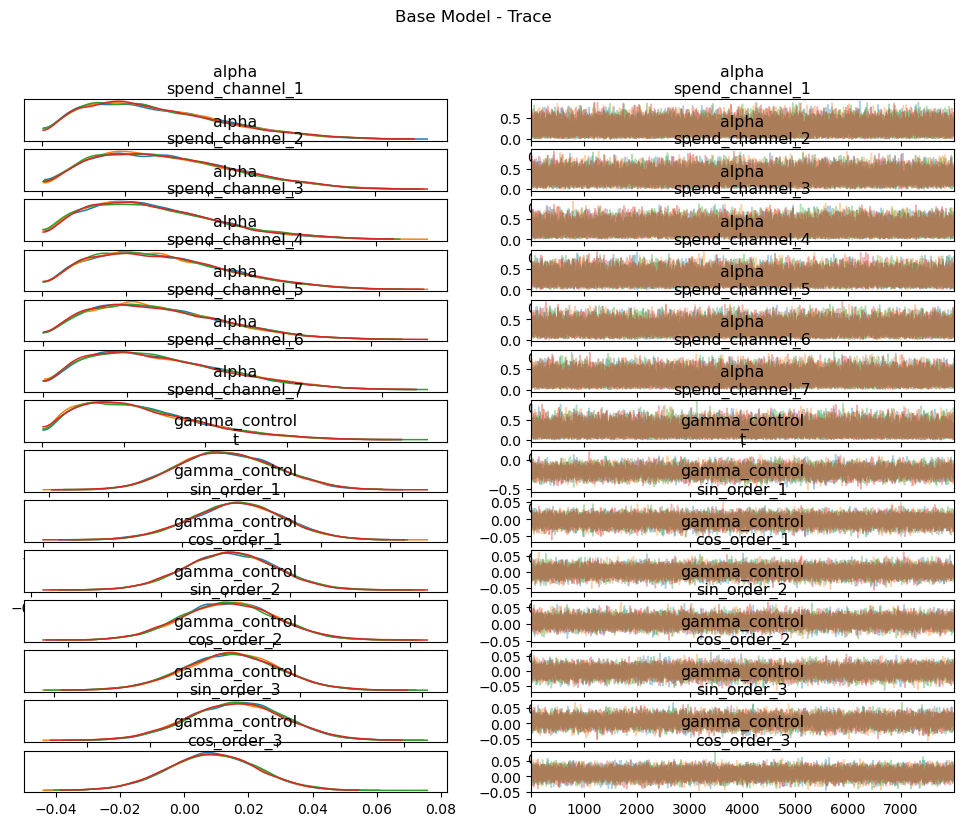

In [17]:
axes = az.plot_trace(
    data=model_trace,
    var_names=['alpha','gamma_control'],
    compact=False,
    backend_kwargs={
        "figsize": (12, 9),
#         "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [ ]:
## posterior prediction

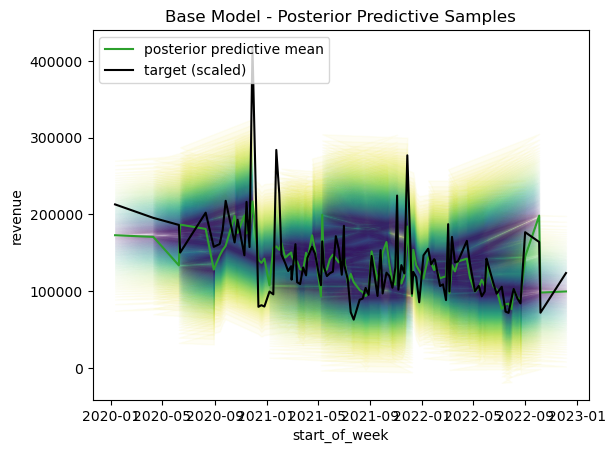

In [13]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)
